# Predicting Kickstarter project success using ML models

The data cleaning was performed in the Jupyter notebook file: ```'1_Data_Cleaning.ipynb'```, which produces the file ```'Kickstarter_clean.csv'```.

This notebook deals with taking the clean data and using machine learning models to predict the outcome of a Kickstarter project.

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import itertools

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

### Loading cleaned data

In [2]:
df = pd.read_csv('data/Kickstarter_clean.csv', sep=',')

In [3]:
# Examining the features of the cleaned dataset
df.head()

,backers_count,category,country,goal,staff_pick,usd_pledged,target,blurb_length,name_length,subcategory,duration_days,year,month
0,21,music,US,200.0,0,802.00000,1,26,4,rock,45,2013,12
1,97,art,US,400.0,0,2259.00000,1,9,5,mixed media,20,2019,2
2,88,photography,US,27224.0,1,29638.00000,1,25,9,photobooks,30,2016,11
3,193,fashion,IT,45461.0,0,49075.15252,1,13,5,footwear,41,2018,10
4,20,technology,US,1000.0,0,549.00000,0,22,4,software,30,2015,3


## Preprocessing the data 

In [4]:
# Convert some columns to categorical
df['country'] = df['country'].astype('category')
df['category'] = df['category'].astype('category')
df['staff_pick'] = df['staff_pick'].astype('category')
df['year'] = df['year'].astype('category')
df['month'] = df['month'].astype('category')

```backers_count``` and ``usd_pledged`` are quantities that are known at the deadline of the project. It stands to reason that the higher the number of backers and the higher the amount pledged, the more likely a project is to succeed. We want to predict at the launch of the project whether it will be successful or not and the number of backers and amount pledged is not known at the start of a project's launch.

In [5]:
# Defining target and feature variables
y = df['target']
X = df.drop(['target','backers_count','usd_pledged','subcategory'], axis=1)

In [6]:
X.head()

,category,country,goal,staff_pick,blurb_length,name_length,duration_days,year,month
0,music,US,200.0,0,26,4,45,2013,12
1,art,US,400.0,0,9,5,20,2019,2
2,photography,US,27224.0,1,25,9,30,2016,11
3,fashion,IT,45461.0,0,13,5,41,2018,10
4,technology,US,1000.0,0,22,4,30,2015,3


In [7]:
# Make copy of features DataFrame for error analysis later
Xc = X.copy()
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, y, test_size=0.3, stratify=y, random_state=RSEED)

In [8]:
# Creating dummy variables
col_dummies = ['category', 'country', 'staff_pick', 'year', 'month']
X_dum = pd.get_dummies(X[col_dummies], drop_first=True)
X.drop(col_dummies, axis=1, inplace=True)
X = pd.concat([X, X_dum], axis=1)

In [9]:
X.head()

,goal,blurb_length,name_length,duration_days,category_comics,category_crafts,category_dance,category_design,category_fashion,category_film & video,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,200.0,26,4,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,400.0,9,5,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,27224.0,25,9,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,45461.0,13,5,41,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,1000.0,22,4,30,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


After creating the dummy variables, we can see that the dataset consists of mostly categorical features.

In [10]:
# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RSEED)

In [11]:
# Print columns that will be scaled
col_scale = list(X.dtypes[(X.dtypes == 'float64') | (X.dtypes == 'int64')].index)
print("Columns that will be scaled:", col_scale)

Columns that will be scaled: ['goal', 'blurb_length', 'name_length', 'duration_days']


In [12]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[col_scale] = scaler.fit_transform(X_train[col_scale])
X_test_scaled[col_scale] = scaler.transform(X_test[col_scale])

## Machine learning models

Since we have many categorical features, tree-based models are more suitable for training our model. We also consider a simple logistic regression model. It is not necessary to scale the features for the tree-based models, however scaled data is used for the logistic regression model.

The models under consideration are:
1. Logistic regression
2. Decision tree
3. Random forest
4. Stochastic Gradient Boost (XGBoost)
5. Adaboost

### 1. Logistic regression

In [13]:
logreg = LogisticRegression(random_state=RSEED)
logreg.fit(X_train_scaled, y_train)

y_pred_train = logreg.predict(X_train_scaled)
y_pred_test = logreg.predict(X_test_scaled)

print("Precision on train data: ", round(precision_score(y_train, y_pred_train),3))
print("Accuracy on train data :  ", round(accuracy_score(y_train, y_pred_train),3))

print("Precision on test data: ", round(precision_score(y_test, y_pred_test),3))
print("Accuracy on test data :  ", round(accuracy_score(y_test, y_pred_test),3))

Precision on train data:  0.734
Accuracy on train data :   0.721
Precision on test data:  0.732
Accuracy on test data :   0.721


### 2. Decision Tree

In [14]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train) 

y_pred_train = dtree.predict(X_train)
y_pred_test = dtree.predict(X_test)

print("Precision on train data: ", round(precision_score(y_train, y_pred_train),3))
print("Accuracy on train data :  ", round(accuracy_score(y_train, y_pred_train),3))

print("Precision on test data: ", round(precision_score(y_test, y_pred_test),3))
print("Accuracy on test data :  ", round(accuracy_score(y_test, y_pred_test),3))

Precision on train data:  1.0
Accuracy on train data :   0.999
Precision on test data:  0.699
Accuracy on test data :   0.662


### 3. Random forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rf = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=42,
                       verbose=1)

In [16]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Precision on train data: ", round(precision_score(y_train, y_pred_train),3))
print("Accuracy on train data :  ", round(accuracy_score(y_train, y_pred_train),3))

print("Precision on test data: ", round(precision_score(y_test, y_pred_test),3))
print("Accuracy on test data :  ", round(accuracy_score(y_test, y_pred_test),3))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Precision on train data:  0.999
Accuracy on train data :   0.999
Precision on test data:  0.752
Accuracy on test data :   0.736


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


### 4. Stochastic Gradient Boost (XGBoost)

In [17]:
xgb = XGBClassifier(random_state=RSEED)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [18]:
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

print("Precision on train data: ", round(precision_score(y_train, y_pred_train),3))
print("Accuracy on train data :  ", round(accuracy_score(y_train, y_pred_train),3))

print("Precision on test data: ", round(precision_score(y_test, y_pred_test),4))
print("Accuracy on test data :  ", round(accuracy_score(y_test, y_pred_test),4))

Precision on train data:  0.782
Accuracy on train data :   0.775
Precision on test data:  0.76
Accuracy on test data :   0.7511


### 6. Adaboost

In [19]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=RSEED) 
clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

In [20]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Precision on train data: ", round(precision_score(y_train, y_pred_train),3))
print("Accuracy on train data :  ", round(accuracy_score(y_train, y_pred_train),3))

print("Precision on test data: ", round(precision_score(y_test, y_pred_test),3))
print("Accuracy on test data :  ", round(accuracy_score(y_test, y_pred_test),3))

Precision on train data:  1.0
Accuracy on train data :   0.999
Precision on test data:  0.717
Accuracy on test data :   0.696


The decision tree, random forest and Adaboost models showed a significant difference in the precision and accuracy between the train and test data set, which is indicative of overfitting.

## Best model

XGBoost gave the best results "out of the box", so we will run a grid search and cross validation using it.

In [547]:
estimator = XGBClassifier(random_state=RSEED)

param_grid = {
    'max_depth': [4, 5, 6, 7, 8],
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': [0.3, 0.4, 0.5, 0.6]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring = 'precision',
    cv = 5,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...learning_rate=0.4, max_depth=5, n_estimators=100; total time=   4.2s
[CV] END ...learning_rate=0.4, max_depth=5, n_estimators=100; total time=   4.0s
[CV] END ...learning_rate=0.4, max_depth=5, n_estimators=100; total time=   3.5s
[CV] END ...learning_rate=0.4, max_depth=5, n_estimators=100; total time=   3.6s
[CV] END ...learning_rate=0.4, max_depth=5, n_estimators=100; total time=   3.9s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [549]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print("Precision on train data: ", round(precision_score(y_train, y_pred_train),3))
print("Accuracy on train data :  ", round(accuracy_score(y_train, y_pred_train),3))

print("Precision on test data: ", round(precision_score(y_test, y_pred_test),3))
print("Accuracy on test data :  ", round(accuracy_score(y_test, y_pred_test),3))

print("Best params: ", best_params)
print("\n")
print(classification_report(y_test, y_pred_test))

Precision on train data:  0.767
Accuracy on train data :   0.756
Precision on test data:  0.752
Accuracy on test data :   0.741
Best params:  {'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 100}


              precision    recall  f1-score   support

           0       0.72      0.66      0.69     22260
           1       0.75      0.80      0.78     28434

    accuracy                           0.74     50694
   macro avg       0.74      0.73      0.73     50694
weighted avg       0.74      0.74      0.74     50694



## Confusion matrix

In [21]:
# Confusion matrix on train and test data
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

In [22]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        print("--------"*5)
    else:
        print('Confusion matrix, without normalization:')
        print("--------"*5)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization:
----------------------------------------


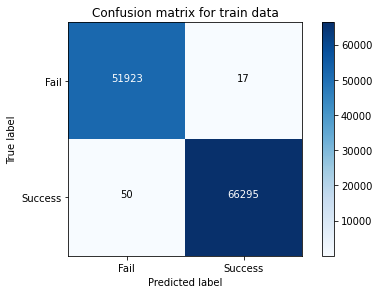

In [23]:
plot_confusion_matrix(cm_train, classes=['Fail', 'Success'], normalize=False, title='Confusion matrix for train data')

Confusion matrix, without normalization:
----------------------------------------


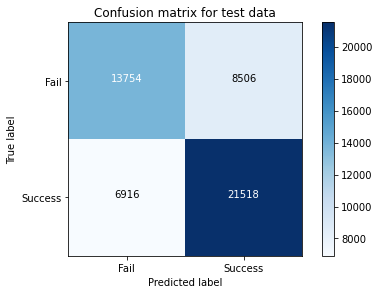

In [24]:
plot_confusion_matrix(cm_test, classes=['Fail', 'Success'], normalize=False, title='Confusion matrix for test data')

### Save false positive (FP) and false negative (FN) rows for later error analysis

Exploratory Data Analysis will be done on the rows where the predicted values do not match the target values to understand how the model can be improved. A DataFrame with only the observations where the target and predicted value do not match is saved. 

In [25]:
y_pred_train = pd.DataFrame(y_pred_train, columns=['y_pred_train']).set_index(y_train.index)
df_error = pd.concat([Xc_train, y_train, y_pred_train], axis=1)
df_error = df_error.query('target != y_pred_train')
df_error.head()

,category,country,goal,staff_pick,blurb_length,name_length,duration_days,year,month,target,y_pred_train
26646,music,US,5000.0,0,18,4,30,2017,5,1,0
106535,publishing,US,15000.0,0,25,3,30,2015,8,1,0
93053,food,US,25000.0,0,19,4,30,2016,5,1,0
67922,comics,US,2000.0,0,21,2,30,2016,5,0,1
55046,film & video,US,5000.0,0,21,3,30,2014,5,1,0


In [26]:
df_error.to_csv('data/Kickstarter_error_analysis.csv', sep=',')